In [1]:
root = "C:/Users/egorg/Projects/MemcoinsTradingBotPolygon"; import sys; sys.path.append(root)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import src.utils as util

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
from src.env.data import ScalarFeatures

In [3]:
# pd.options.display.float_format = '{:,.8f}'.format

In [ ]:
data_path = f"{root}/data"
shift = int(180 / 60)
datasets = util.load_datasets(data_path, shift)
len(datasets)

5049

In [5]:
df = util.dataset_to_dataframe(datasets)
df

,dataset,std,rstd,ma_distance_ratio,rsi_crossovers,rsi_crossunders,entropy,regression_slope,regression_sqr,volatility_clustering,max_drawdown_ratio,time_to_trough_ratio,recovery_ratio,path_length_ratio,sign_change_ratio,drawdown_convexity,drop_velocity,regime
0,0_10,6.523627e-08,0.136456,0.048904,1,0,3.023363,0.002367,0.784891,0.045169,0.264656,0.371901,0.177214,4.362858,0.550000,0.000027,0.711631,17
1,0_11,3.956624e-08,0.080538,0.027044,1,0,3.189496,-0.001863,0.944745,-0.086710,0.269681,0.479339,0.161490,8.111862,0.541667,-0.000034,0.562611,13
2,0_12,2.014306e-08,0.044340,0.019405,1,0,2.179471,-0.000821,0.972760,-0.026485,0.172131,0.495868,0.107142,7.887888,0.675000,0.000006,0.347130,11
3,0_13,2.400482e-08,0.056238,0.017800,1,0,2.219783,-0.001350,0.980654,-0.048117,0.159574,0.586777,0.119998,6.321927,0.700000,-0.000014,0.271950,36
4,0_14,1.724124e-08,0.042506,0.024766,1,0,2.412590,-0.000219,0.966406,0.429391,0.195294,0.082645,0.399980,55.487590,0.650000,-0.000012,2.363053,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5044,9_4,2.109971e-07,0.085310,0.021940,4,0,2.649813,-0.002241,0.866363,0.056508,0.231712,0.537190,0.089124,3.195684,0.600000,-0.000018,0.431340,13
5045,9_5,1.526912e-07,0.067886,0.025938,4,0,1.965845,-0.001244,0.564301,0.122511,0.248213,0.925620,0.073600,3.151982,0.566667,0.000015,0.268158,36
5046,9_6,2.925304e-07,0.120796,0.043184,2,1,1.646462,0.002239,0.470154,-0.016312,0.211578,0.272727,0.094861,7.242251,0.533333,-0.000017,0.775788,17
5047,9_7,1.469328e-07,0.054975,0.034891,0,1,1.963904,0.000559,0.368129,-0.018669,0.108043,0.528926,0.316293,3.423444,0.600000,-0.000016,0.204268,37


In [38]:
features_selected: list[str] = ["path_length_ratio", "drop_velocity", "max_drawdown_ratio", "rstd", "regression_slope", "ma_distance_ratio"]

In [39]:
features: list[list[np.float64 | int]] = []
for dataset in datasets:
    if dataset.features is None: continue
    scalar: ScalarFeatures = dataset.features.scalar
    buf: list[np.float64 | int] = []
    for e in features_selected:buf.append(getattr(scalar, e))
    features.append(buf)
scaler = StandardScaler()
kmeans_x = np.array(features, dtype=np.float64)
kmeans_x_scaled = scaler.fit_transform(kmeans_x)

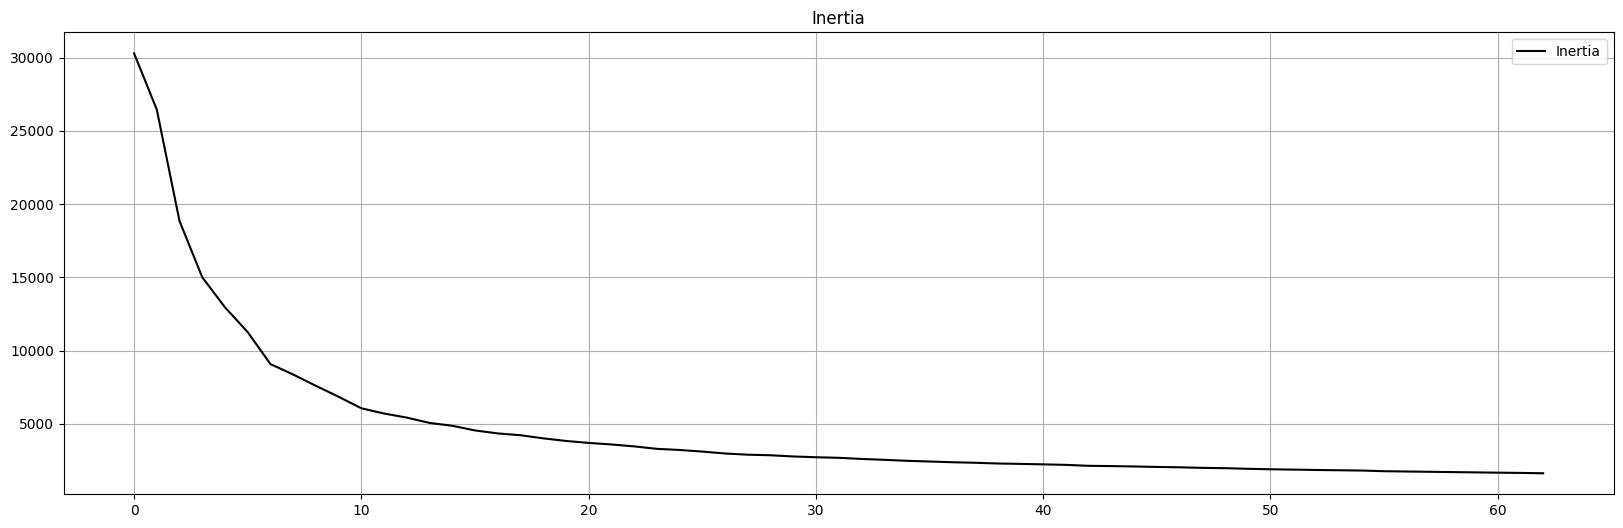

,k,score
0,2,0.941579
1,3,0.375391
2,4,0.380203
3,5,0.375510
4,6,0.321776
...,...,...
57,59,0.231529
58,60,0.227318
59,61,0.230301
60,62,0.230113


In [40]:
util.kmeans_inertia(kmeans_x_scaled, 1, 64)
best_k, max_score, scores = util.kmeans_silhouette(kmeans_x_scaled, 2, 64)
scores

In [41]:
k = 42
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(kmeans_x_scaled)
df["regime"] = labels
df

,dataset,std,rstd,ma_distance_ratio,rsi_crossovers,rsi_crossunders,entropy,regression_slope,regression_sqr,volatility_clustering,max_drawdown_ratio,time_to_trough_ratio,recovery_ratio,path_length_ratio,sign_change_ratio,drawdown_convexity,drop_velocity,regime
0,0_10,6.523627e-08,0.136456,0.048904,1,0,3.023363,0.002367,0.784891,0.045169,0.264656,0.371901,0.177214,4.362858,0.550000,0.000027,0.711631,23
1,0_11,3.956624e-08,0.080538,0.027044,1,0,3.189496,-0.001863,0.944745,-0.086710,0.269681,0.479339,0.161490,8.111862,0.541667,-0.000034,0.562611,25
2,0_12,2.014306e-08,0.044340,0.019405,1,0,2.179471,-0.000821,0.972760,-0.026485,0.172131,0.495868,0.107142,7.887888,0.675000,0.000006,0.347130,1
3,0_13,2.400482e-08,0.056238,0.017800,1,0,2.219783,-0.001350,0.980654,-0.048117,0.159574,0.586777,0.119998,6.321927,0.700000,-0.000014,0.271950,1
4,0_14,1.724124e-08,0.042506,0.024766,1,0,2.412590,-0.000219,0.966406,0.429391,0.195294,0.082645,0.399980,55.487590,0.650000,-0.000012,2.363053,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5044,9_4,2.109971e-07,0.085310,0.021940,4,0,2.649813,-0.002241,0.866363,0.056508,0.231712,0.537190,0.089124,3.195684,0.600000,-0.000018,0.431340,25
5045,9_5,1.526912e-07,0.067886,0.025938,4,0,1.965845,-0.001244,0.564301,0.122511,0.248213,0.925620,0.073600,3.151982,0.566667,0.000015,0.268158,36
5046,9_6,2.925304e-07,0.120796,0.043184,2,1,1.646462,0.002239,0.470154,-0.016312,0.211578,0.272727,0.094861,7.242251,0.533333,-0.000017,0.775788,20
5047,9_7,1.469328e-07,0.054975,0.034891,0,1,1.963904,0.000559,0.368129,-0.018669,0.108043,0.528926,0.316293,3.423444,0.600000,-0.000016,0.204268,38


In [42]:
df["regime"].value_counts()

regime
19    413
11    390
12    383
7     369
1     346
16    344
34    307
38    259
36    229
29    222
25    190
0     182
39    161
3     150
20    130
9     105
27     94
17     93
21     76
41     71
33     67
5      59
26     56
6      56
23     52
13     42
35     31
32     31
37     22
10     22
24     19
4      18
30     17
18     14
8       9
15      8
40      5
14      2
22      2
31      1
2       1
28      1
Name: count, dtype: int64

In [43]:
# cluster_size = 49
# df_features = pd.DataFrame(kmeans_x_scaled, columns=features_selected)
# df_features["cluster"] = labels
# cluster_indexes = util.select_cluster_groups(kmeans_x_scaled, labels, kmeans.cluster_centers_, cluster_size)
cluster_indexes = np.arange(0, len(kmeans_x_scaled) - 1, 1)
len(cluster_indexes)

5048

In [44]:
df_computable = df.iloc[cluster_indexes].copy()
df_computable

,dataset,std,rstd,ma_distance_ratio,rsi_crossovers,rsi_crossunders,entropy,regression_slope,regression_sqr,volatility_clustering,max_drawdown_ratio,time_to_trough_ratio,recovery_ratio,path_length_ratio,sign_change_ratio,drawdown_convexity,drop_velocity,regime
0,0_10,6.523627e-08,0.136456,0.048904,1,0,3.023363,0.002367,0.784891,0.045169,0.264656,0.371901,0.177214,4.362858,0.550000,0.000027,0.711631,23
1,0_11,3.956624e-08,0.080538,0.027044,1,0,3.189496,-0.001863,0.944745,-0.086710,0.269681,0.479339,0.161490,8.111862,0.541667,-0.000034,0.562611,25
2,0_12,2.014306e-08,0.044340,0.019405,1,0,2.179471,-0.000821,0.972760,-0.026485,0.172131,0.495868,0.107142,7.887888,0.675000,0.000006,0.347130,1
3,0_13,2.400482e-08,0.056238,0.017800,1,0,2.219783,-0.001350,0.980654,-0.048117,0.159574,0.586777,0.119998,6.321927,0.700000,-0.000014,0.271950,1
4,0_14,1.724124e-08,0.042506,0.024766,1,0,2.412590,-0.000219,0.966406,0.429391,0.195294,0.082645,0.399980,55.487590,0.650000,-0.000012,2.363053,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5043,9_34,6.442794e-08,0.033984,0.017856,0,0,2.651549,0.000642,0.811227,-0.037977,0.071540,0.000000,0.000000,8.496358,0.591667,-0.000011,0.000000,16
5044,9_4,2.109971e-07,0.085310,0.021940,4,0,2.649813,-0.002241,0.866363,0.056508,0.231712,0.537190,0.089124,3.195684,0.600000,-0.000018,0.431340,25
5045,9_5,1.526912e-07,0.067886,0.025938,4,0,1.965845,-0.001244,0.564301,0.122511,0.248213,0.925620,0.073600,3.151982,0.566667,0.000015,0.268158,36
5046,9_6,2.925304e-07,0.120796,0.043184,2,1,1.646462,0.002239,0.470154,-0.016312,0.211578,0.272727,0.094861,7.242251,0.533333,-0.000017,0.775788,20


In [45]:
# computable_paths = [root + "/data/features/features_" + row["dataset"] + ".json" for _, row in df_computable.iterrows()]
# util.copy_files(computable_paths, f"{root}/data/features/processable")

In [46]:
MIN_SAMPLES_PER_REGIME = 10
x = df_computable[features_selected].values.astype(np.float64)
y = df_computable["regime"].astype(int).values
mask = np.isfinite(x).all(axis=1)
x = x[mask]
y = y[mask]
regime_counts = pd.Series(y).value_counts()
valid_regimes = regime_counts[regime_counts >= MIN_SAMPLES_PER_REGIME].index.values
valid_mask = np.isin(y, valid_regimes)
x = x[valid_mask]
y = y[valid_mask]
y = pd.Series(y).astype("category").cat.codes.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4266, 6), (753, 6), (4266,), (753,))

In [47]:
# x, y = df_computable[features_selected].values.astype(np.float64), df_computable["regime"].astype("category").cat.codes.astype(int)
# mask = np.isfinite(x).all(axis=1)
# x = x[mask]
# y = y[mask]
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)
# x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [48]:
train_set = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
test_set = lgb.Dataset(x_test, label=y_test, reference=train_set, free_raw_data=False)

In [49]:
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight = dict(zip(classes, weights))
pd.DataFrame({"class": classes, "weight": weights})

,class,weight
0,0,0.809488
1,1,0.426771
2,2,0.987957
3,3,8.364706
4,4,2.509412
5,5,2.613971
6,6,0.399588
7,7,1.409782
8,8,6.603715
9,9,0.379065


In [50]:
classes_count = len(np.unique(y))
model = LGBMClassifier(
    num_class=classes_count,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=5,
    min_data_in_leaf=30,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=5,
    class_weight=class_weight,
    random_state=42,
    n_estimators=500
)
model.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,"{np.int8(0): np.float64(0.8094876660341556), np.int8(1): np.float64(0.4267707082833133), np.int8(2): np.float64(0.9879573876794813), np.int8(3): np.float64(8.364705882352942), ...}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [51]:
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

c:\Users\egorg\Projects\MemcoinsTradingBotPolygon\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.94      0.94      0.94        52
           2       0.91      0.87      0.89        23
           3       1.00      1.00      1.00         3
           4       0.80      0.89      0.84         9
           5       0.88      0.88      0.88         8
           6       1.00      0.91      0.95        55
           7       0.88      0.88      0.88        16
           8       1.00      0.67      0.8

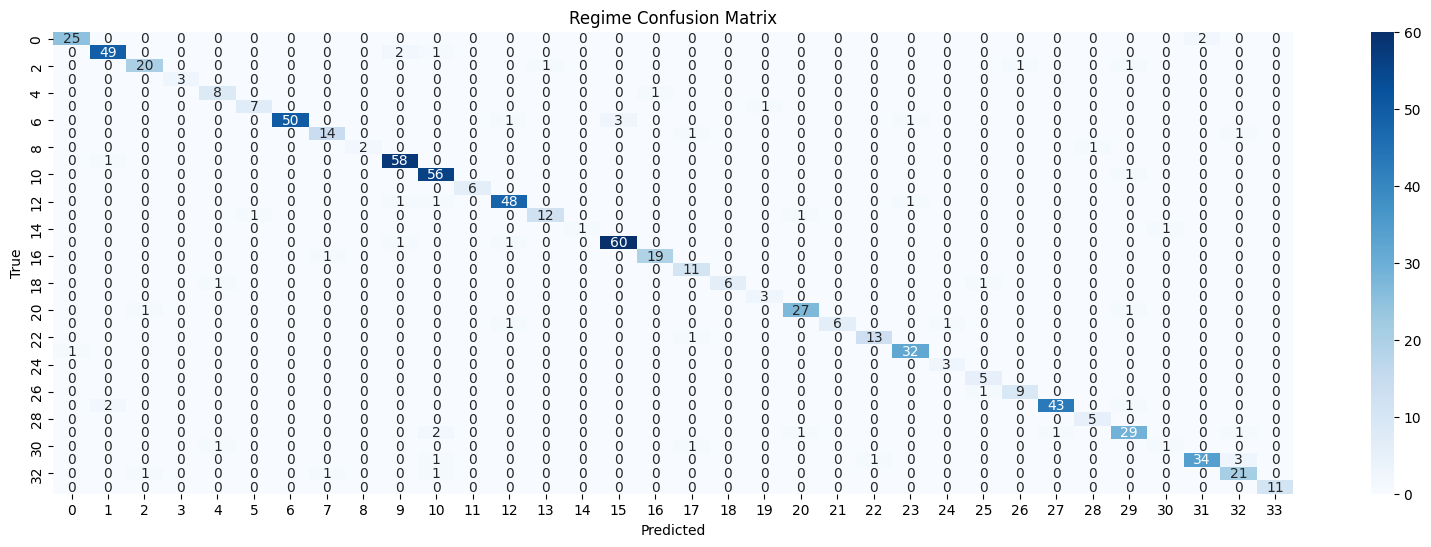

In [52]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Regime Confusion Matrix")
plt.show()

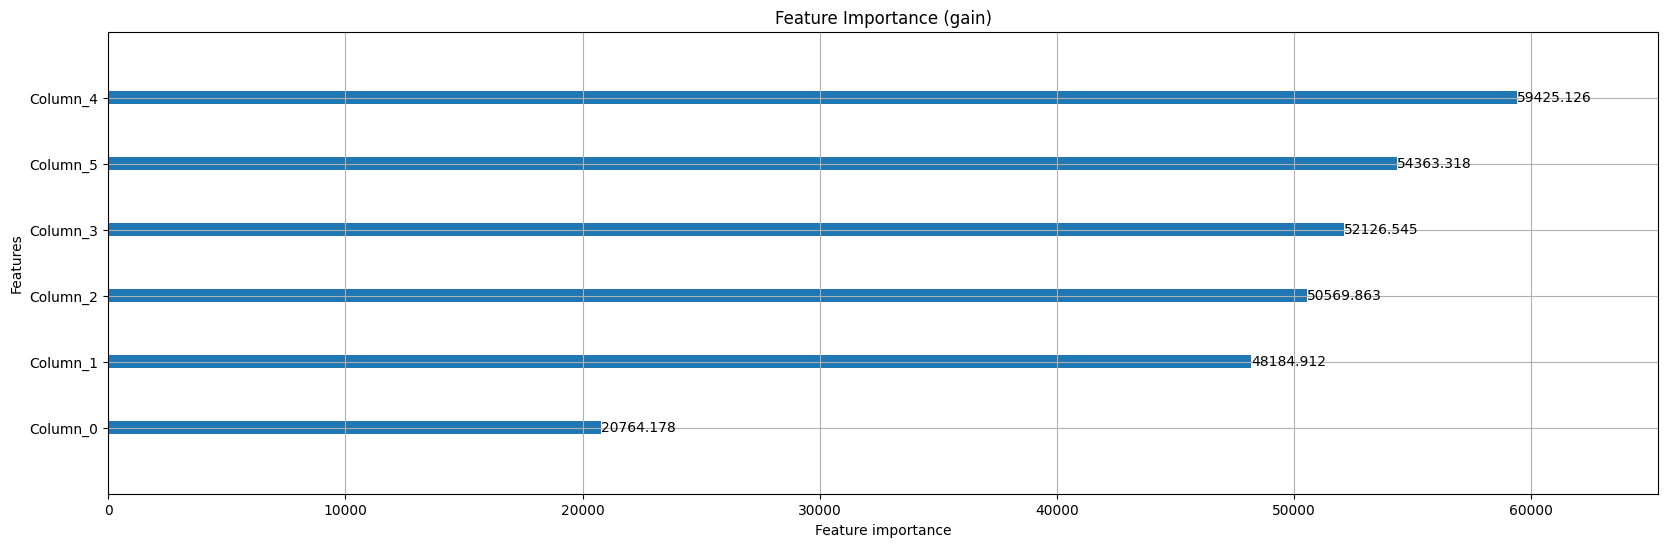

In [53]:
lgb.plot_importance(model, importance_type="gain", figsize=(20, 6))
plt.title("Feature Importance (gain)")
plt.show()

In [55]:
df[["dataset", "regime"]].to_csv(f"{root}/data/dataset_regime_map.csv", index=False)